<a href="https://colab.research.google.com/github/errec-sun/brain/blob/master/8_ghbvth_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D1%8F_8_%D0%90%D1%83%D0%B4%D0%B8%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Подключаем библиотеки
from google.colab import files #Загрузка файлов
from tensorflow.keras import utils #Для to_categorical
import os #Работа с папками и файлами
import librosa #Параметризация аудио
import numpy as np #Numpy массивы
import matplotlib.pyplot as plt #Отображение графиков
#Отрисовка графиков в ячейках collab
%matplotlib inline 

from tensorflow.keras.optimizers import Adam, RMSprop #Оптимизатор для задания шага обучения
from tensorflow.keras.models import Sequential, Model #Два формата модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, MaxPooling2D, MaxPooling1D, GlobalMaxPooling2D #Базовые слови
from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler #Для нормировки данных

#Отключаем предупреждения
import warnings
warnings.filterwarnings('ignore')

In [0]:
#Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')
#Базу для ноутбука можно скачать по ссылке
#http://marsyas.info/downloads/datasets.html

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/Базы/genres.zip', 'r')
z.extractall()

#Задаём названия жанров
#В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [0]:
#Функция параметризации аудир
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = np.mean(librosa.feature.chroma_stft(y = y, sr = sr)) #Частота цветности
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y = y, sr = sr)) #Спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y = y, sr = sr)) #Ширина полосы частот
  rolloff = np.mean(librosa.feature.spectral_rolloff(y = y, sr = sr)) #Спектральный спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y = y, sr = sr) #Мел кепстральные коэффициенты
  
  #Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))
  
  #Возвращаем получившийся список
  return out

In [0]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

seconds = 20

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые %seconds% секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=seconds)
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Жанр blues готов -> 68c
Жанр classical готов -> 69c
Жанр country готов -> 68c
Жанр disco готов -> 68c
Жанр hiphop готов -> 68c
Жанр jazz готов -> 68c
Жанр metal готов -> 68c
Жанр pop готов -> 68c
Жанр reggae готов -> 68c
Жанр rock готов -> 68c


In [0]:
#Создаём scaler для нормировки в нормальное распределение
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(np.array(X_train, dtype = float))

In [0]:
#Выводим номера классов, чтобы проверить, что всё правильно заполнилось
#И номера классов идут последовательно крупными блоками
y_train_class = np.argmax(Y_train, axis=1)

In [0]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [0]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


In [0]:
#Функция параметризации аудир
def get_features_2d(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности
  rmse = librosa.feature.rmse(y=y) #Среднеквадратичная амплитуда
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) #Спектральный центроид
  #spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Ширина полосы частот
  #rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  #zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел спектральные коэффициенты
  
  #Возвращаем получившийся список
  return mfcc, chroma_stft, rmse, spec_cent

In [0]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train_mfcc = []
X_train_chroma_stft = []
X_train_rmse = []
X_train_spec_cent = []
Y_train = []
#Запоминаем время старта формирования выборки
curr_time = time.time()

seconds = 20

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые %seconds% секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=seconds)
    #Превращаем сигнал в параметризованные данныеБМ и питон ещё нет

    for sec in range(seconds):
      mfcc, chroma_stft, rmse, spec_cent = get_features_2d(y[sec*sr:(sec+1)*sr], sr)
      X_train_mfcc.append(mfcc)
      X_train_chroma_stft.append(chroma_stft)
      X_train_rmse.append(rmse)
      X_train_spec_cent.append(spec_cent)
      Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train_mfcc = np.array(X_train_mfcc)
X_train_chroma_stft = np.array(X_train_chroma_stft)
X_train_rmse = np.array(X_train_rmse)
X_train_spec_cent = np.array(X_train_spec_cent)
Y_train = np.array(Y_train)

Жанр blues готов -> 68c
Жанр classical готов -> 67c
Жанр country готов -> 68c
Жанр disco готов -> 68c
Жанр hiphop готов -> 69c
Жанр jazz готов -> 70c
Жанр metal готов -> 71c
Жанр pop готов -> 72c
Жанр reggae готов -> 73c
Жанр rock готов -> 73c


In [0]:
print(X_train_mfcc.shape)
print(X_train_chroma_stft.shape)
print(X_train_rmse.shape)
print(X_train_spec_cent.shape)
print(Y_train.shape)

(20000, 20, 44)
(20000, 12, 44)
(20000, 1, 44)
(20000, 1, 44)
(20000, 10)


In [0]:
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0], X_train_mfcc.shape[1], X_train_mfcc.shape[2], 1)
X_train_chroma_stft = X_train_chroma_stft.reshape(X_train_chroma_stft.shape[0], X_train_chroma_stft.shape[1], X_train_chroma_stft.shape[2], 1)
X_train_rmse = X_train_rmse.reshape(X_train_rmse.shape[0], X_train_rmse.shape[2], X_train_rmse.shape[1])
X_train_spec_cent = X_train_spec_cent.reshape(X_train_spec_cent.shape[0], X_train_spec_cent.shape[2], X_train_spec_cent.shape[1])

In [0]:
print(X_train_mfcc.shape)
print(X_train_chroma_stft.shape)
print(X_train_rmse.shape)
print(X_train_spec_cent.shape)
print(Y_train.shape)

(20000, 20, 44, 1)
(20000, 12, 44, 1)
(20000, 44, 1)
(20000, 44, 1)
(20000, 10)


In [0]:
#Создаём backup обучающей выборки
X_train_mfcc_backup = X_train_mfcc.copy()
X_train_chroma_stft_backup = X_train_chroma_stft.copy()
X_train_rmse_backup = X_train_rmse.copy()
X_train_spec_cent_backup = X_train_spec_cent.copy()
Y_train_backup = Y_train.copy()

In [0]:
val_mask = np.random.sample(20000)
train_mask = val_mask < 0.8
val_mask = val_mask >= 0.8

In [0]:
print(train_mask.shape)

(20000,)


In [0]:
print(train_mask[:100])

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True False  True  True False  True  True  True
  True  True False False  True  True  True  True False  True  True  True
  True  True  True  True  True  True False False  True False False  True
 False False False  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True False  True False  True False  True
 False  True  True  True  True False  True  True  True False  True  True
  True  True  True  True  True False  True  True  True  True  True False
 False  True  True  True]


In [0]:
def scale(X):
  min_X = X.min()
  max_X = X.max()
  X = (X - min_X) / (max_X - min_X)

  return X

In [0]:
X_train_mfcc_scaled = scale(X_train_mfcc)
X_train_chroma_stft_scaled = scale(X_train_chroma_stft)
X_train_rmse_scaled = scale(X_train_rmse)
X_train_spec_cent_scaled = scale(X_train_spec_cent)

##Создаём нейронку

Epoch 1/20
63/63 [==============================] - 10s 153ms/step - loss: 1.6709 - accuracy: 0.4390 - val_loss: 8.2053 - val_accuracy: 0.1015
Epoch 2/20
63/63 [==============================] - 9s 139ms/step - loss: 1.2899 - accuracy: 0.5543 - val_loss: 27.7355 - val_accuracy: 0.1008
Epoch 3/20
63/63 [==============================] - 9s 139ms/step - loss: 1.3667 - accuracy: 0.5521 - val_loss: 3.3614 - val_accuracy: 0.1124
Epoch 4/20
63/63 [==============================] - 9s 139ms/step - loss: 1.2309 - accuracy: 0.5656 - val_loss: 3.4808 - val_accuracy: 0.2045
Epoch 5/20
63/63 [==============================] - 9s 138ms/step - loss: 1.0082 - accuracy: 0.6605 - val_loss: 3.1127 - val_accuracy: 0.3022
Epoch 6/20
63/63 [==============================] - 9s 138ms/step - loss: 1.4284 - accuracy: 0.5309 - val_loss: 2.0027 - val_accuracy: 0.2942
Epoch 7/20
63/63 [==============================] - 9s 139ms/step - loss: 1.1511 - accuracy: 0.5952 - val_loss: 3.7588 - val_accuracy: 0.3082
Epoc

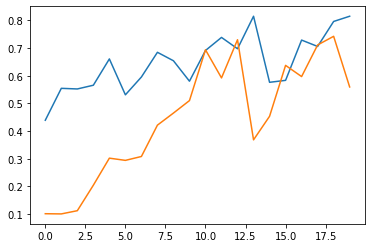

In [0]:
input_mfcc = Input((20, 44, 1))
input_chroma_stft = Input((12, 44, 1))
input_rmse = Input((44, 1))
input_spec_cent = Input((44, 1))

x1 = BatchNormalization()(input_mfcc)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Flatten()(x1)

x2 = BatchNormalization()(input_chroma_stft)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2_gmp_1 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2_gmp_2 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2_gmp_3 = GlobalMaxPooling2D()(x2)
x2 = Flatten()(x2)

x3 = BatchNormalization()(input_rmse)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Flatten()(x3)

x4 = BatchNormalization()(input_spec_cent)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Flatten()(x4)

x = concatenate([x1, x2, x3, x4, x2_gmp_1, x2_gmp_2, x2_gmp_3])

x = Dense(128, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model([input_mfcc, input_chroma_stft, input_rmse, input_spec_cent], x)

model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit([X_train_mfcc_scaled[train_mask], X_train_chroma_stft_scaled[train_mask], X_train_rmse_scaled[train_mask], X_train_spec_cent_scaled[train_mask]],
                    Y_train[train_mask],
                    epochs=20,
                    batch_size=256,
                    validation_data=([X_train_mfcc_scaled[val_mask], X_train_chroma_stft_scaled[val_mask], X_train_rmse_scaled[val_mask], X_train_spec_cent_scaled[val_mask]],
                    Y_train[val_mask]))

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

Epoch 1/200
45/45 [==============================] - 0s 6ms/step - loss: 2.0465 - accuracy: 0.2356 - val_loss: 1.8752 - val_accuracy: 0.3200
Epoch 2/200
45/45 [==============================] - 0s 3ms/step - loss: 1.7662 - accuracy: 0.3678 - val_loss: 1.7303 - val_accuracy: 0.3200
Epoch 3/200
45/45 [==============================] - 0s 3ms/step - loss: 1.6293 - accuracy: 0.4000 - val_loss: 1.6383 - val_accuracy: 0.3500
Epoch 4/200
45/45 [==============================] - 0s 3ms/step - loss: 1.5360 - accuracy: 0.4200 - val_loss: 1.5689 - val_accuracy: 0.3900
Epoch 5/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4667 - accuracy: 0.4756 - val_loss: 1.5217 - val_accuracy: 0.4300
Epoch 6/200
45/45 [==============================] - 0s 3ms/step - loss: 1.4090 - accuracy: 0.5056 - val_loss: 1.4921 - val_accuracy: 0.4400
Epoch 7/200
45/45 [==============================] - 0s 3ms/step - loss: 1.3603 - accuracy: 0.5289 - val_loss: 1.4526 - val_accuracy: 0.5200
Epoch 8/200
4

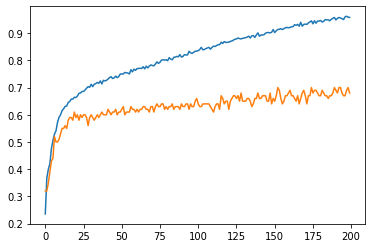

In [0]:
#Указываем, какие индексы данных во входных векторах брать для обучения
#Делаем это для того, чтобы можно было экспериментировать
#И обучать не на всех колонках данных, а на части
indexes = range(0,26)

#Создаём Dense сеть
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(len(indexes),)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце 10 нейронов и softmax, так как 10 классов
model.add(Dense(10, activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train[:, indexes],
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test[:, indexes], y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()